In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path
from tqdm import tqdm

%matplotlib inline

class FineLane():
    def __init__(self):
        self.width = 1280
        self.height = 720
        
    """fine the Laneline from car camera image"""
    def calibrate_camera(self,force=False):
        """load the file"""
        chessboard_images='./camera_cal/*.jpg'
        """save the file for reusing"""
        dis_matrix_file='distort_mtx.p'
        
        if os.path.isfile(dis_matrix_file) and not force:
            # load camera distortion matrix if already exists
            dist_pickle = pickle.load(open(dis_matrix_file, 'rb'))
            self.camera = {
                'mtx': dist_pickle['mtx'],
                'dist': dist_pickle['dist'],
            }
        else:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
          # Start calibrating camera
            # prepare object points
            nx, ny = 9, 5
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []  # 3D coord in real world
            imgpoints = []  # 2D coord in image plane

            calibration_img_paths = glob.glob(chessboard_images)
            # use tqdm to display progress bar
            for img_path in tqdm(calibration_img_paths):
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret == True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                objpoints, imgpoints, img_size, None, None)

            # Save the camera calibration result for later use
            self.camera = {
                'mtx': mtx,
                'dist': dist,
            }
            # Save camera matrix to avoid recalibrating every time
            # run with force=True to force recalibrate
            pickle.dump(self.camera, open(dis_matrix_file, 'wb'))
    def undistort(self,img):
        """Undistort image using camera matrix"""
        assert 'mtx' in self.camera
        assert 'dist' in self.camera
        mtx = self.camera['mtx']
        dist = self.camera['dist']
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist
    def get_bird_eye_transform_matrix(self,reverse=False):
        tls = (563, 470)  # top left source point
        bls = (220, 700)  # bottom left source point
        tld = (300, 300)  # top left destination 
        bld = (300, 720)  # bottom left destination
        
        src = np.float32([
            [tls[0], tls[1]],
            [self.width-tls[0], tls[1]],
            [self.width-bls[0], bls[1]],
            [bls[0], bls[1]]
        ])

        dst = np.float32([
            [tld[0], tld[1]],
            [self.width-tld[0], tld[1]],
            [self.width-tld[0], bld[1]],
            [bld[0], bld[1]],
        ])
        
        if reverse:
            transform_mtx = cv2.getPerspectiveTransform(dst, src)
        else:
            transform_mtx = cv2.getPerspectiveTransform(src, dst)
        return transform_mtx
    def bird_eye_transform(self,img,reverse=False):
        """Change the car camera image into bird eyes view"""
        transform_mtx = self.get_bird_eye_transform_matrix(reverse=reverse)
        shape = (self.width, self.height)
        warped = cv2.warpPerspective(
            img, transform_mtx, shape, flags=cv2.INTER_LINEAR)
        return warped
        


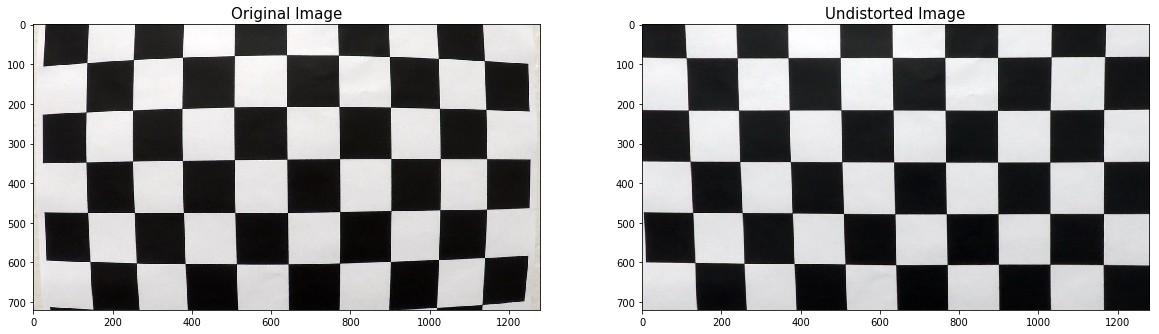

In [29]:
img_size = (720, 1280)
lf = FineLane()
lf.calibrate_camera()
img = cv2.imread('./camera_cal/calibration1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = lf.undistort(img)
# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/chessboard_original.jpg', rgb)
plt.imsave('./output_images/chessboard_undistort.jpg', undist)



In [30]:
test_images=[
    
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',

    
]
f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    warped = lf.bird_eye_transform(rgb)
    axarr[idx][0].imshow(rgb)
    axarr[idx][1].imshow(warped)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
